# Anomaly Detection with Isolation Forest

### Notes from Infosec's Cybersecurity Data Science Learning Path
* <u>Isolation Forest</u>: anomaly detection algorithm. Uses trees to describe points, and those points that are EASILY DESCRIBED: are anomalous.
* <u>Anomaly Detection</u>: identifying rare events that raise suspicion by differing significantly from most of the data
    * Advantage - can detect previously unseen (zero-day) events
* <u>Decision function</u>: the number of splittings of the trees required to describe a point. The larger this number, the more "normal" the point.

In [1]:
## Simple Example with made up data ##
#two distributions: one normal, one anomalous

import numpy as np
rng = np.random.RandomState(42)
nNorm = 2000
nAnom = 200
X_norm = np.r_[0.5 * rng.randn(int(nNorm/2), 2), 0.5 * rng.randn(int(nNorm/2), 2)]
y_norm = nNorm * [0]
X_anom = rng.uniform(low=-5, high=5, size=(nAnom, 2))
y_anom = nAnom*[1]

In [2]:
#Print data for normal data
print(X_norm.shape)
print(X_norm[0:5])

(2000, 2)
[[ 0.24835708 -0.06913215]
 [ 0.32384427  0.76151493]
 [-0.11707669 -0.11706848]
 [ 0.78960641  0.38371736]
 [-0.23473719  0.27128002]]


In [3]:
#Print data for anomalous data
print(X_anom.shape)
print(X_anom[0:5])

(200, 2)
[[-0.14982012 -4.1459697 ]
 [ 4.7246139   0.18010431]
 [ 1.14186244 -2.63390217]
 [-0.16501915 -0.70850508]
 [-4.25104158 -3.93839646]]


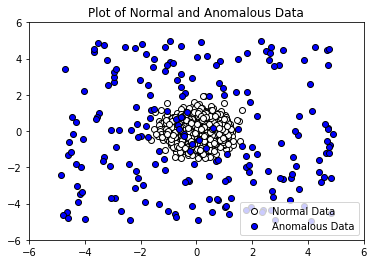

In [4]:
#Plot these points
%matplotlib inline
import matplotlib.pyplot as plt

p_norm = plt.scatter(X_norm[:,0], X_norm[:,1], c ='white', edgecolor = 'black')
p_anom = plt.scatter(X_anom[:,0], X_anom[:,1], c ='blue', edgecolor = 'black')

plt.title("Plot of Normal and Anomalous Data")
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.legend([p_norm,p_anom],
          ["Normal Data", "Anomalous Data"],
          loc="lower right")
plt.show() #some anomalous data seem completely "normal"

In [5]:
#Create a train/test split
#put both normal and anomalous data into the training dataset

from sklearn.model_selection import train_test_split
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y_norm, test_size = 0.2)
X_anom_train, X_anom_test, y_anom_train, y_anom_test = train_test_split(X_anom, y_anom, test_size = 0.2)
X_train = np.concatenate([X_norm_train, X_anom_train])
y_train = np.concatenate([y_norm_train, y_anom_train])
X_test = np.concatenate([X_norm_test, X_anom_test])
y_test = np.concatenate([y_norm_test, y_anom_test])

In [6]:
#Build the Isolation Forest Model
from sklearn.ensemble import IsolationForest
clf = IsolationForest()
clf.fit(X_train) #fit model on training data

C:\Users\604906\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\604906\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

Text(0.5, 1.0, 'Distribution of Anomaly Scores for Normal Training Data')

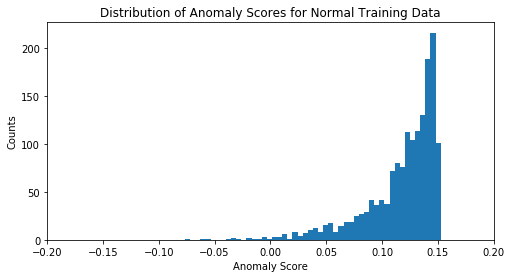

In [7]:
#Compute the decision function of all the "normal" part of the training data
train_scores = clf.decision_function(X_norm_train)
fig = plt.figure(figsize=(8,4))
normal = plt.hist(train_scores, bins = 50) # adding "density = True" option converts counts -> probability density (Area under hist: 1)
plt.xlim(-0.2, 0.2)
plt.xlabel('Anomaly Score')
plt.ylabel('Counts')
plt.title("Distribution of Anomaly Scores for Normal Training Data")

Text(0.5, 1.0, 'Distribution of Anomaly Scores for Anomalous Training Data')

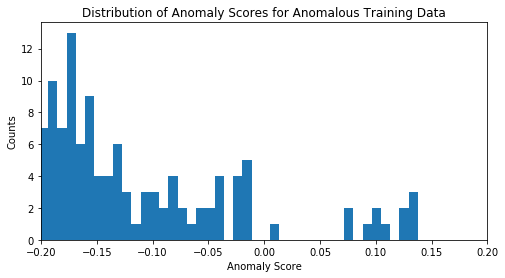

In [8]:
#Do the same for the anomalous training data
train_scores = clf.decision_function(X_anom_train)
fig = plt.figure(figsize=(8,4))
normal = plt.hist(train_scores, bins = 50)
plt.xlim(-0.2, 0.2) #use the same X axis as above
plt.xlabel('Anomaly Score')
plt.ylabel('Counts')
plt.title("Distribution of Anomaly Scores for Anomalous Training Data")

In [9]:
#How do we separate the two to distinguish normal vs. anomalous?
#Use a cutoff point of "0.0" by visual inspection 
cutoff = 0.0

In [10]:
#Score the model
def FPR(y_true, y_pred): # normal point misclassified as anomalous : "false alarm"
    Tot_Neg = sum(y_true == 0)
    FP = sum(y_pred[y_true == 0] == 1)
    return str(float(FP)/float(Tot_Neg)*100) + "%"

def TPR(y_true, y_pred): # anomalous point correctly classified as anomalous
    Tot_Pos = sum(y_true == 1)
    TP = sum(y_pred[y_true == 1] == 1)
    return str(float(TP)/float(Tot_Pos)*100) + "%"

In [11]:
#Compute these two metrics using the cutoff of 0.0
#for the training set
print(FPR(y_train, (cutoff > clf.decision_function(X_train)).astype(int))) #FPR: 0.875%
print(TPR(y_train, (cutoff > clf.decision_function(X_train)).astype(int))) #correctly captures 92.5% of anomalies

0.8750000000000001%
92.5%


In [12]:
#Do the same for the test set
print(FPR(y_test, (cutoff > clf.decision_function(X_test)).astype(int))) #FPR: 0.5%
print(TPR(y_test, (cutoff > clf.decision_function(X_test)).astype(int))) #correctly captures 95% of anomalies

0.5%
95.0%


## Do the same exercise with another example dataset ##
